In [2]:
#import all necessary PyQuil libraries and global constants
from pyquil.api import get_qc
from pyquil.quil import Program
from pyquil.api import QVM
from pyquil.api._devices import list_lattices
from pyquil.paulis import PauliTerm, exponential_map
from pyquil.gates import RZ, Z, H, MEASURE, CNOT, RESET
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Physical constants, global variable
H_BAR = 0.658212    # eV*fs
Jxy = 0.01183898    # eV, coupling coeff; Jz<0 is antiferromagenetic, Jz>0 is ferromagnetic
FREQ = 0.0048       # 1/fs, frequency of MoSe2 phonon

In [3]:
def evolution_circuit(qubits, delta_t, total_time, w_ph):
    """
    Define circuit for evolution of wavefunction, i.e.,
    H(t) = - Jxy * (sigma_{x}^{0} * sigma_{x}^{1} + sigma_{y}^{0} * sigma_{y}^{1} + sigma_{x}^{2} * sigma_{x}^{3} + sigma_{y}^{2} * sigma_{y}^{3} + sigma_{x}^{0} * sigma_{x}^{2} + sigma_{y}^{0} * sigma_{y}^{2} + sigma_{x}^{1} * sigma_{x}^{3} + sigma_{y}^{1} * sigma_{y}^{3})
           - e_ph * cos(w_ph * t) * (sigma_{z}^{0} + sigma_{z}^{1} + 2 * sigma_{z}^{2} + 2 * sigma_{z}^{3})

    Args:
    - qubits: list of qubits in system
    - delta_t: unit of propagation time 
    - total_time: total time to evolve system
    - w_ph: angular frequency of phonon
    
    Return: 
    - pyquil.Progra
    """

    # get the number of qubits
    nqubits = len(qubits)
    e_ph = 0.5*Jz
    #instantiate program object for return
    p = Program(RESET())

    # decalre time e_ph as a parameter
    # declare memory for read out
    ro = p.declare('ro', memory_type='BIT', memory_size=nqubits)

    # determine number of time steps to get to total time
    prop_steps = int(total_time / delta_t)
    
    # instantiate program object for the propagator to which
    # we add terms of Hamiltonian piece by piece
    for step in range(0,prop_steps):
        t = (step + 0.5) * delta_t
        propagator_t = Program()
        instr_set1 = []
        instr_set2 = []
        theta_z = -e_ph * np.cos(w_ph * t)

        #make coupling terms
        coupling_terms = []
        coupling_terms = PauliTerm("X", qubits[0], Jxy)*PauliTerm("X", qubits[1]) + PauliTerm("Y", qubits[0], Jxy)*PauliTerm("Y", qubits[1]) \
                        + PauliTerm("X", qubits[2], Jxy)*PauliTerm("X", qubits[3]) + PauliTerm("Y", qubits[2], Jxy)*PauliTerm("Y", qubits[3]) \
                        + PauliTerm("X", qubits[0], Jxy)*PauliTerm("X", qubits[2]) + PauliTerm("Y", qubits[0], Jxy)*PauliTerm("Y", qubits[2]) \
                        + PauliTerm("X", qubits[1], Jxy)*PauliTerm("X", qubits[3]) + PauliTerm("Y", qubits[1], Jxy)*PauliTerm("Y", qubits[3])
        #make transverse magnetization terms of Hamiltonian
        Hz = []
        Hz = PauliTerm("Z", qubits[0], theta_z) + PauliTerm("Z", qubits[1], theta_z) + 2 * PauliTerm("Z", qubits[2], theta_z) + 2 * PauliTerm("Z", qubits[3], theta_z)
        for j in range(0, len(Hz)):
            instr_set1.append(exponential_map(Hz[j])(delta_t/H_BAR))
        for j in range(0, len(coupling_termsZ)):
            instr_set2.append(exponential_map(coupling_terms[j])(delta_t/H_BAR))

        # create propagator 
        propagator_t.inst(instr_set1, instr_set2)
        p.inst(propagator_t)

    # add measurement operators to each qubit
    for i in range(0,nqubits):
        p.inst(MEASURE(qubits[i], ro[i]))
    
    # return program 
    return p

In [4]:
if __name__=="__main__":
    
    #qc = get_qc("9q-generic-qvm", as_qvm=True)
    #qc = get_qc(device_name==sys.argv[1].strip())
    print('hello')
    qvm = get_qc('9q-square-qvm')
    qubits = qvm.qubits()
    num_qubits = len(qubits) 
    trials = 100
    # should have total_t divisible by delta_t
    delta_t = 3     # fs
    total_t = 150  # fs
    num_steps = int(total_t / delta_t) + 1

    # define the terms of the Hamiltonian
    w_ph = 2.0 * np.pi * FREQ   # 1/fs

    # loop over time steps
    with open("results.npy", "wb") as f:
        np.save(f, (trials, num_qubits, num_steps, 1))
        for i in range(0, num_steps):
            # compute total time to evolve wavefunction under for this step of loop
            evolution_time = delta_t * i
            #create program 
            program = evolution_circuit(qubits, delta_t, evolution_time, w_ph)
            # wrap program in loop for ntrials, compile program, and run
            program.wrap_in_numshots_loop(trials)
            #convert quil to native quil (native set of gates)
            nqp = qc.compiler.quil_to_native_quil(program)
            #compile to executable
            executable = qc.compiler.native_quil_to_executable(nqp)
            #run the code on the pre-defined backend
            bitstrings = qc.run(executable)
            ##Save bitstrings to file
            np.save(f, bitstrings)

hello


NameError: name 'Jz' is not defined

In [5]:
import numpy as np
import os
import csv

def average_magnetization(result: dict, shots: int):
  """Compute average magnetization from results of qk.execution.
  Args:
  - result (dict): a dictionary with the counts for each qubit, see qk.result.result module
  - shots (int): number of trials
  Return:
  - average_mag (float)
  """
  mag = 0
  for spin_str, count in result.items():
    spin_int = [1 - 2 * float(s) for s in spin_str]
    mag += (sum(spin_int) / len(spin_int)) * count
  average_mag = mag / shots
  return average_mag


if __name__=="__main__":
  infile = 'results.npy'
  outfile = 'averages.txt'
  avg_mag = []
  with open('results.npy', 'rb') as f:
    trails, nqubits, num_steps, len_ephs = np.load(f,allow_pickle=True)
    for i in range(1, num_steps):
      results = []
      for j in range(len_ephs):
        bitstrings = np.load(f)
        for t in range(0, trails):
          for q in range(0, nqubits):
            if bitstrings[t][q] == 0:
              bitstrings[t][q] = 1.0
            else:
              bitstrings[t][q] = -1.0
        results.append(np.mean([bitstrings[:,0]]))
      for e in range(0, len_ephs):
        avg_mag.append(results[e])
        print(e,avg_mag[e])
  f.close()
  with open("averages.txt", "w") as f:
      np.save(f, (range(num_steps-1), avg_mag))
  f.close()

ValueError: Cannot load file containing pickled data when allow_pickle=False

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

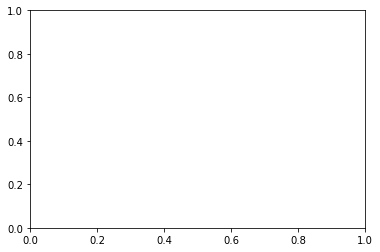

In [6]:
plt.plot(range(num_steps-1), avg_mag)
plt.show()